# Infer ***cytoplasm*** from a composite image - 1️⃣ 
### Alternative workflow: ***"a"*** (an alternative workflow for images with NO **nuclei** or **cell membrane** makers)
--------------

## OVERVIEW
We will start by segmenting the different cell regions - the nucleus, cell, and cytoplasm - since they will be necessary for determining which organelle are in which cell. This is integral to our single cell analysis approach.

This notebook goes through the workflow steps to segment the ***cytoplasm*** from a composite image.


## OBJECTIVE: 
### ✅ Infer sub-cellular component #1: ***cytoplasm***
Segment the ***cytoplasm*** from a composite image of multiple organelle markers combined. The ***cell*** and ***nuclei*** masks will be derived from this mask.

> ***Biological relevance:***
> The combination of organelle markers used to create the composite image for the cytoplasm segmentation is based on the assumption that the organelle labels used will "fill up" the entire cytoplasm (not including the nucleus). This is NOT the most accurate method to determine the cell area, but is required in the case where membrane and nuclei markers can not or are not included. This largely depends on the organelle labeles used and the cell type. 
>
> *It is important to consider specifics of your system as the cell type and labeling method may differ from the example above.*



### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Union, Tuple, List

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                     read_ome_image,
                                     import_inferred_organelle,
                                     export_inferred_organelle,
                                     list_image_files)

                                             
from infer_subc.core.img import *
from infer_subc.organelles import (get_nuclei, 
                                   non_linear_cellmask_transform,
                                   choose_max_label_cellmask_union_nucleus)


%load_ext autoreload
%autoreload 2


## Get and load Image for processing

In [3]:
test_img_n = 0

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

in_data_path = data_root_path / "neuron_raw_OME"
im_type = ".tiff"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "neuron_raw_OME_out-06012023"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

---------
## infer ***cytoplasm*** from composite image

### summary of steps

➡️ INPUT
- create composite image from multiple organelle channels

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)
- log transform image
- apply scharr edge detection filter 
- combine log imge + scharr edge filtered intensity

CORE PROCESSING
- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

POST-PROCESSING
- fill holes (hole size = user input)
- remove small objects (object size = user input)

OUTPUT ➡️ 
- save single ***cellmask*** (cell, CM) at unsigned integer 8-bit tif files


## EXTRACTION prototype

In [5]:
###################
# INPUT
###################
# Creating a composite image
weights =  [0, 4, 1, 1, 2, 2]
struct_img_raw = weighted_aggregate(img_data, *weights)

## PRE-PROCESSING prototype

> **NOTE**: No smoothing was done here because these test images were already pre-processed.

In [6]:
###################
# PRE_PROCESSING
###################
med_filter_size = 0
gaussian_smoothing_sigma = 0

structure_img_smooth = scale_and_smooth(struct_img_raw,
                                        median_size = med_filter_size, 
                                        gauss_sigma = gaussian_smoothing_sigma)

In [7]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cellmask = non_linear_cellmask_transform(structure_img_smooth)

## CORE PROCESSING prototype

In [8]:
###################
# CORE_PROCESSING
###################
# threshold the composite image after log/edge detection using the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
thresh_method = 'ave'
cutoff_size =  50
thresh_adj = 0.2

bw = masked_object_thresh(composite_cellmask, 
                          global_method=thresh_method, 
                          cutoff_size=cutoff_size, 
                          local_adjust=thresh_adj)

## POST-PROCESSING prototype

In [9]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 30

small_object_width = 10

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size= small_object_width,
                                           method=fill_filter_method)

## POST POST-PROCESSING prototype

In [10]:
cytoplasm_mask = label_bool_as_uint16(cleaned_img2)

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [13]:
viewer = napari.view_image(img_data)

18-Jan-24 11:30:45 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 2172x1322-1152-1608 (frame: 2194x1378-1163-1653) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY2". Resulting geometry: 2606x1587-1150-1601 (frame: 2628x1643-1161-1646) margins: 11, 45, 11, 11 minimum size: 385x498 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=792,1052 maxtrack=0,0)


masks_A.json, 
selecting 0: 20230817_C2-123_unconditioned_well 2_cell 1_50 uM NaAsO_Linear unmixing_0_cmle.ome:masks_A
btn_run_clicked - 0: {'rescale': True, 'weight_ch0': 1, 'weight_ch1': 4, 'weight_ch2': 1, 'weight_ch3': 1, 'weight_ch4': 0, 'weight_ch5': 2, 'weight_ch6': 0, 'weight_ch7': 0, 'weight_ch8': 0, 'weight_ch9': 0}
selecting 1: Create composite image
btn_run_clicked - 1: {'gauss_sigma': 0.0, 'median_size': 0}
selecting 2: Rescale and smooth image
btn_run_clicked - 2: None
selecting 3: Log transform + Scharr edge detection
btn_run_clicked - 3: {'cutoff_size': 50, 'global_method': 'ave_tri_med', 'local_adjust': 0.05}
selecting 3: Log transform + Scharr edge detection
btn_run_clicked - 3: {'cutoff_size': 50, 'global_method': 'ave_tri_med', 'local_adjust': 0.1}
btn_run_clicked - 3: {'cutoff_size': 50, 'global_method': 'ave_tri_med', 'local_adjust': 0.1}
btn_run_clicked - 3: {'cutoff_size': 500, 'global_method': 'ave_tri_med', 'local_adjust': 0.1}
selecting 0: -20230817_C2-123_un

In [12]:
viewer.add_image(
    composite_cellmask)

viewer.add_labels(
    cytoplasm_mask,
    opacity=0.3)

<Labels layer 'cytoplasm_mask' at 0x21f31fca290>

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\napari\utils\_proxies.py:188: FutureWarning: This event will be removed in 0.5.0. Please use viewer.layers.events instead
  return self.create(self.__wrapped__(*args, **kwargs))


masks_A.json, 
selecting 0: img_data:masks_A
btn_run_clicked - 0: {'rescale': True, 'weight_ch0': 1, 'weight_ch1': 4, 'weight_ch2': 1, 'weight_ch3': 1, 'weight_ch4': 0, 'weight_ch5': 2, 'weight_ch6': 0, 'weight_ch7': 0, 'weight_ch8': 0, 'weight_ch9': 0}
selecting 1: Create composite image
btn_run_clicked - 1: {'gauss_sigma': 0.0, 'median_size': 0}
selecting 2: Rescale and smooth image
btn_run_clicked - 2: None
selecting 3: Log transform + Scharr edge detection
btn_run_clicked - 3: {'cutoff_size': 50, 'global_method': 'ave_tri_med', 'local_adjust': 0.05}
btn_run_clicked - 3: {'cutoff_size': 50, 'global_method': 'ave_tri_med', 'local_adjust': 0.05}
btn_run_clicked - 3: {'cutoff_size': 50, 'global_method': 'ave_tri_med', 'local_adjust': 0.05}


## SAVE inferred nuclei to .tif file

Based on the _prototyping_ above define the function to infer nuclei.  


In [12]:
out_file_n = export_inferred_organelle(cytoplasm_mask, "cyto", meta_dict, out_data_path)

saved file: 20221027_C2-107_well_1_cell_1_untreated_Linear_unmixing_decon.ome-cyto


----------
## DEFINE `infer_cytoplasm_fromcomposite` function

Based on the _prototyping_ above define the function to infer nuclei. 

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
# infer_cytoplasm_fromcomposite
# alternative workflow "a"
##########################
def _infer_cytoplasm_fromcomposite(in_img: np.ndarray,
                                  weights: list[int],
                                  median_sz: int,
                                  gauss_sig: float,
                                  mo_method: str,
                                  mo_adjust: float,
                                  mo_cutoff_size: int,
                                  min_hole_w: int,
                                  max_hole_w: int,
                                  small_obj_w: int,
                                  fill_filter_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimu object size cutoff for cellmask signal post-processing
    watershed_method:
        determines if the watershed should be run 'sice-by-slice' or in '3D' 

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = weighted_aggregate(in_img, *weights)

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = scale_and_smooth(struct_img,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                      global_method=mo_method, 
                                      cutoff_size=mo_cutoff_size, 
                                      local_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size= small_obj_w,
                                             method=fill_filter_method)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = label_bool_as_uint16(struct_obj)

    return cellmask_out

## DEFINE `_fixed_infer_cytoplasm_fromcomposite` function

Based on the _prototyping_ above define the function to infer cellmask. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [14]:
##########################
# fixed_infer_cytoplasm_fromcomposite
# alternative workflow "a"
##########################
def _fixed_infer_cytoplasm_fromcomposite(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels: "
        a 3d image containing the inferred nuclei

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask
    """
    

    ###################
    # PARAMETERS
    ###################   
    weights = [0, 4, 1, 1, 2, 2]
    median_sz = 0
    gauss_sig = 0
    mo_method = "ave"
    mo_adjust = 0.2
    mo_cutoff_size = 50
    hole_min_width = 0
    hole_max_width = 30
    small_obj_w = 10
    fill_filter_method = '3D'

    cellmask_out = _infer_cytoplasm_fromcomposite(in_img,
                                                weights,
                                                median_sz,
                                                gauss_sig,
                                                mo_method,
                                                mo_adjust,
                                                mo_cutoff_size,
                                                hole_min_width,
                                                hole_max_width,
                                                small_obj_w,
                                                fill_filter_method) 

    return cellmask_out

## TEST `_infer_cellmask_fromcomposite`  function defined above

In [15]:
_CY_object =  _fixed_infer_cytoplasm_fromcomposite(img_data) 

_CY_object.dtype

dtype('uint16')

In [16]:
np.all(cytoplasm_mask == _CY_object)

True

--------------------------

# TEST `infer_cytoplasm_fromcomposite` exported functions


In [17]:
from infer_subc.organelles.cytoplasm import fixed_infer_cytoplasm_fromcomposite

CY_object =  fixed_infer_cytoplasm_fromcomposite(img_data) 

In [18]:
np.all(_CY_object == CY_object)

True

## Visualize  2


In [19]:
viewer.add_labels(
    _CY_object,
    opacity=0.3)

viewer.add_labels(
    CY_object,
    opacity=0.3)

<Labels layer 'CY_object' at 0x19053d7fd60>

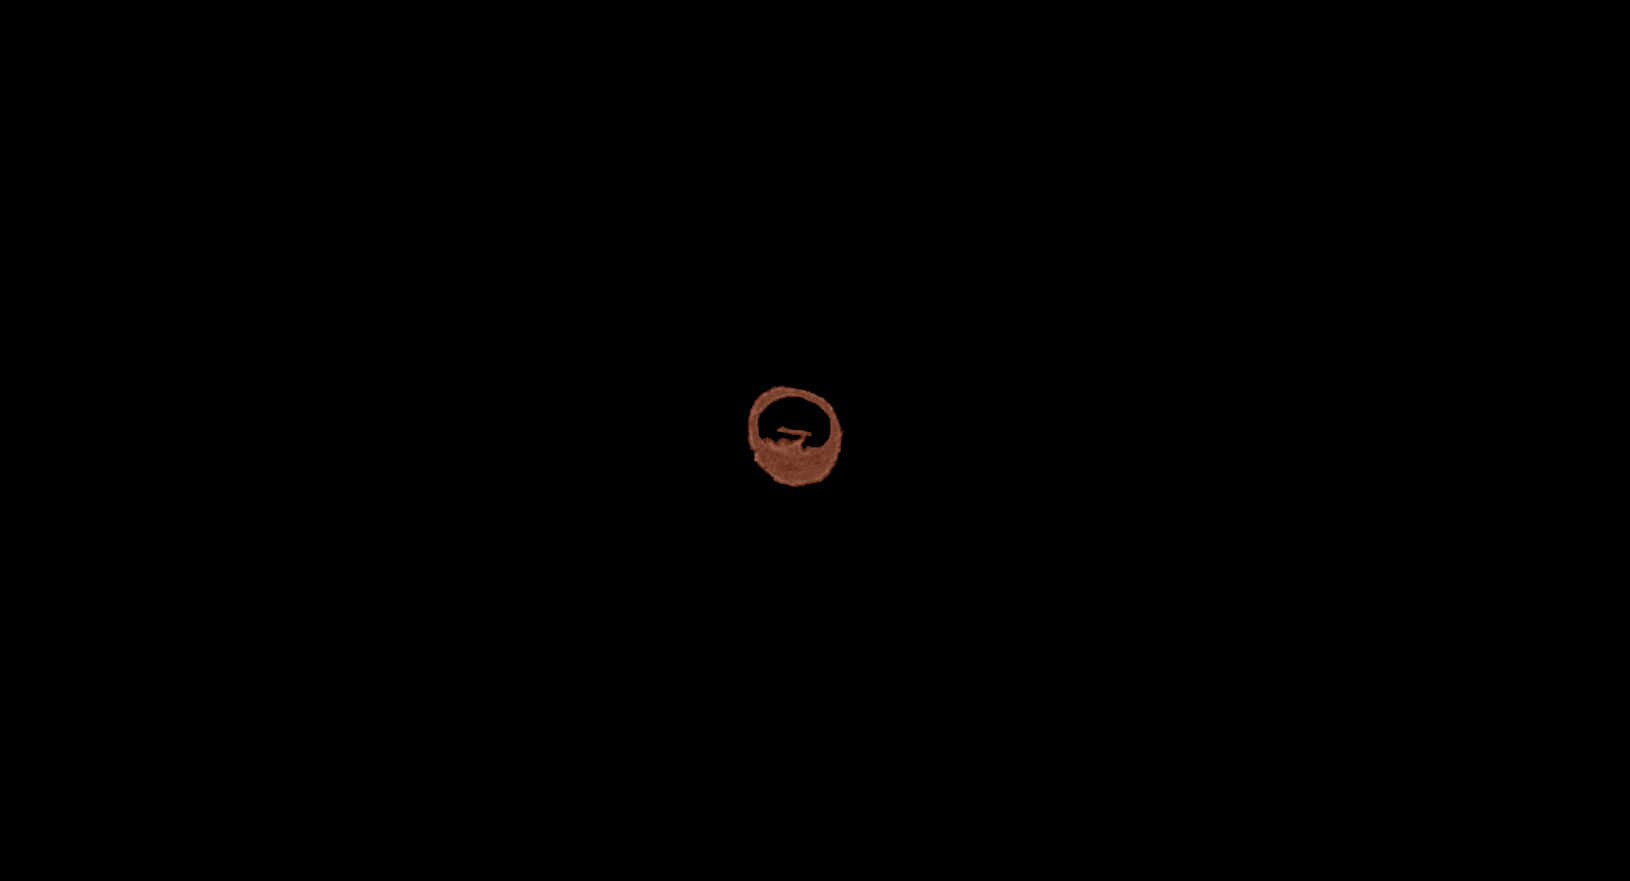

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## SUMMARY

The above details how the cytoplasm object is inferred from a composite image of only cytoplasm organelle markers.  

### NEXT: INFER cellmask (from cytoplasm)

Proceed to [02a_infer_cellmask_from-cytoplasm.ipynb](./02a_infer_cellmask_from-cytoplasm.ipynb)
